In [3]:
import pandas as pd
import numpy as np
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate ,Dropout # type: ignore
# from tensorflow.keras.models import Model # type: ignore
# from sklearn.preprocessing import MultiLabelBinarizer


In [4]:
movies = pd.read_csv("datasets/movies.csv")
ratings = pd.read_csv("datasets/ratings.csv")
tags = pd.read_csv("datasets/tags.csv")
link = pd.read_csv("datasets/links.csv")

In [13]:
print(movies.info())
print(ratings.info())
print(tags.info())
print(link.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    36

In [3]:
tags["tag"] = tags["tag"].str.lower()
tags["tag"] = tags["tag"].str.replace(" ", ",")

In [4]:
movies['genres'] = movies['genres'].str.lower()
movies['genres'] = movies['genres'].str.replace("|",",")

In [5]:
merged_df = pd.merge(movies, tags, on='movieId')
movies = merged_df.groupby(['movieId', 'title', 'genres'])['tag'].apply(lambda x: ', '.join(x)).reset_index()

In [6]:
movies['content'] = movies['genres'] + ',' + movies['tag']

In [7]:
mlb = MultiLabelBinarizer()
genres_encoded = pd.DataFrame(mlb.fit_transform(movies['content']), columns=mlb.classes_, index=movies.index)
movies = pd.concat([movies, genres_encoded], axis=1)


In [8]:
movies_with_ratings = pd.merge(movies,ratings,on='movieId')

In [9]:
movies_with_ratings = movies_with_ratings.sort_values(by=['userId', 'movieId', 'timestamp'], ascending=[True, True, False])
movies_with_ratings = movies_with_ratings.drop_duplicates(subset=['userId', 'movieId'], keep='first')
movies_with_ratings = movies_with_ratings.reset_index(drop=True)

In [10]:
movies_with_ratings['release_year'] = movies_with_ratings['title'].str.extract(r'\((\d{4})\)')
movies_with_ratings['release_year'] = pd.to_numeric(movies_with_ratings['release_year'], errors='coerce')

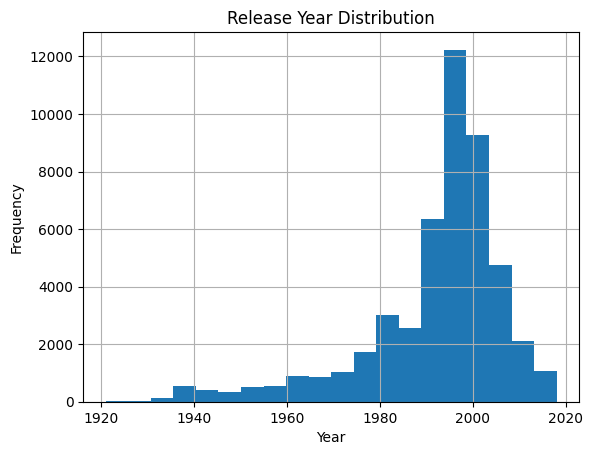

In [11]:
import matplotlib.pyplot as plt
movies_with_ratings['release_year'].hist(bins=20)
plt.title('Release Year Distribution')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()


In [12]:
median_year = movies_with_ratings['release_year'].median()
movies_with_ratings['release_year'] = movies_with_ratings['release_year'].fillna(median_year)

In [13]:
def compute_time_decay(timestamp, current_time, lambda_decay=0.001):
    time_difference = (current_time - timestamp) / (60 * 60 * 24) 
    decay_weight = np.exp(-lambda_decay * time_difference)
    return decay_weight

In [14]:
def compute_year_decay(release_year, latest_year, lambda_year=0.001):
    year_difference = latest_year - release_year
    year_decay_weight = np.exp(-lambda_year * year_difference)
    return year_decay_weight


In [15]:
current_time = movies_with_ratings['timestamp'].max()
movies_with_ratings['time_decay_weight'] = movies_with_ratings['timestamp'].apply(
    lambda x: compute_time_decay(x, current_time)
)

In [16]:
current_year = movies_with_ratings['release_year'].max()
movies_with_ratings['year_decay_weight'] = movies_with_ratings['release_year'].apply(
    lambda x: compute_time_decay(x, current_year)
)

In [17]:
movies_with_ratings['combined_decay'] = (
    movies_with_ratings['time_decay_weight'] * movies_with_ratings['year_decay_weight']
)


In [ ]:
movies_with_ratings['userId'] -= 1
movies_with_ratings['movieId'] -= 1

In [18]:
movies_with_ratings['userId'] -= 1
movies_with_ratings['movieId'] -= 1

train, test = train_test_split(movies_with_ratings, test_size=0.2, random_state=42)

In [24]:
train.shape

(38629, 58)

In [19]:
train['userId'], user_index = pd.factorize(train['userId'])
train['movieId'], movie_index = pd.factorize(train['movieId'])
test['userId'] = test['userId'].map(lambda x: user_index.get_loc(x) if x in user_index else -1)
test['movieId'] = test['movieId'].map(lambda x: movie_index.get_loc(x) if x in movie_index else -1)
test = test[(test['userId'] != -1) & (test['movieId'] != -1)]

In [20]:
user_input = Input(shape=(1,), name='user_input')
item_input = Input(shape=(1,), name='item_input')
genre_input = Input(shape=(len(mlb.classes_),), name='genre_input')

user_embedding = Embedding(input_dim=movies_with_ratings['userId'].nunique(), output_dim=50, name='user_embedding')(user_input)
item_embedding = Embedding(input_dim=movies_with_ratings['movieId'].nunique(), output_dim=50, name='item_embedding')(item_input)

user_vector = Flatten()(user_embedding)
item_vector = Flatten()(item_embedding)

concat = Concatenate()([user_vector, item_vector,genre_input])

dense_1 = Dense(128, activation='relu')(concat)
dense_1 = Dropout(0.3)(dense_1)
dense_2 = Dense(64, activation='relu')(dense_1)
output = Dense(1, activation='sigmoid')(dense_2)


2025-03-05 19:25:49.410140: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [21]:
model = Model([user_input, item_input,genre_input], output)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 50)     │     30,500 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_embedding      │ (None, 1, 50)     │     77,700 │ item_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 50)        │          0 │ user_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 50)        │          0 │ item_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ genre_input         │ (None, 46)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 146)       │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ genre_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     18,816 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 135,337 (528.66 KB)

 Trainable params: 135,337 (528.66 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
train_user = train['userId'].values
train_item = train['movieId'].values
train_rating = (train['rating'].values / 5.0)  * train['combined_decay'].values 
train_genres = train[mlb.classes_].values

test_user = test['userId'].values
test_item = test['movieId'].values
test_rating = (test['rating'].values / 5.0) * test['combined_decay'].values
test_genres = test[mlb.classes_].values

history = model.fit(
    [train_user, train_item,train_genres], train_rating,
    validation_data=([test_user, test_item,test_genres], test_rating),
    epochs=10, batch_size=256, verbose=1
)


Epoch 1/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0563 - val_accuracy: 0.0000e+00 - val_loss: 0.0060
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0055 - val_accuracy: 0.0000e+00 - val_loss: 0.0044
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0041 - val_accuracy: 0.0000e+00 - val_loss: 0.0041
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0038 - val_accuracy: 0.0000e+00 - val_loss: 0.0039
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0038 - val_accuracy: 0.0000e+00 - val_loss: 0.0039
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0033 - val_accuracy: 0.0000e+00 - val_loss: 0.0039
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0033 - val_accuracy: 0.0000e+00 - val_loss: 0.0038
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/s

In [23]:
def recommend_items(user_id, model, n=5):
    item_ids = np.arange(movies_with_ratings['movieId'].nunique())
    user_array = np.full(len(item_ids), user_id)
    genres_array = np.zeros((len(item_ids), len(mlb.classes_)))
    predictions = model.predict([user_array, item_ids,genres_array]).flatten()
    top_n_items = predictions.argsort()[-n:][::-1]
    recommended_movie_ids = [movie_id + 1 for movie_id in movie_index[top_n_items]]
    recommended_movies = movies[movies["movieId"].isin(recommended_movie_ids)]
    recommended_titles = recommended_movies["title"].tolist()
    return recommended_titles

print("Recommended items:", recommend_items(5, model, n=5))

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Recommended items: ['The Martian (2015)', 'The Revenant (2015)', 'Sicario (2015)', 'Big Short, The (2015)', 'Logan (2017)']
